In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from transformers import AutoModelForCausalLM, AutoTokenizer
from src.llms_ocr.errors_calculator_chunks import ErrorsCalculator

### Visualize the error distribution per page

In [2]:
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [3]:
data_dir = Path("../../data/d2_0001-0100_without_marginalia")
out_json_dir = Path("../../data/json")

In [4]:
page_base = "173736378X_00000051"
xml_file = data_dir / f"{page_base}.xml"
xml_file

PosixPath('../../data/d2_0001-0100_without_marginalia/173736378X_00000051.xml')

In [5]:
calc = ErrorsCalculator(
    model=model,
    tokenizer=tokenizer,
)
json_data, frame = calc.process_page(xml_file)

Processing page: 173736378X_00000051


In [9]:
word_smoothed_ppl_page = np.array(calc.word_smoothed_ppl_page)
problematic_regions = np.array(calc.problematic_regions).tolist()
words_list = calc.all_word_texts
all_words_count = len(words_list)
error_words_count = sum(len(region["words"]) for region in problematic_regions)
threshold = 158

Plot the perplexity scores per page, words with values above red line (threshold) are considered to be the error words.

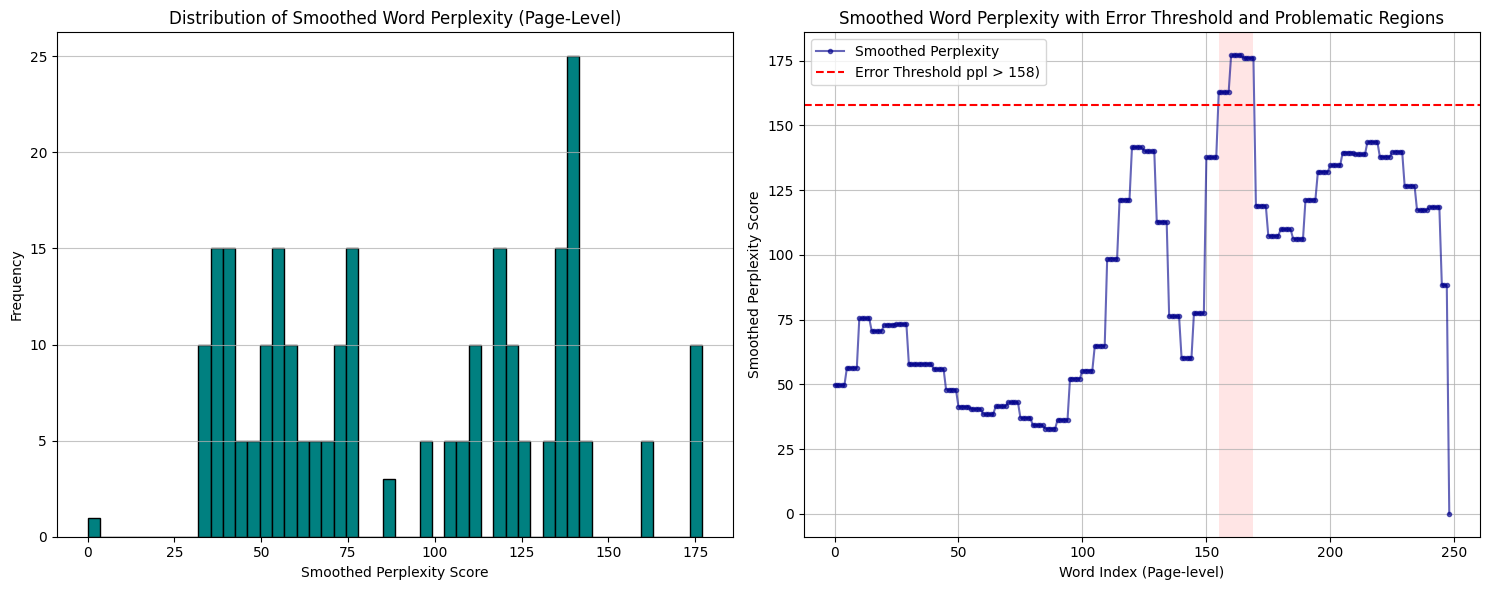

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Histogram of Smoothed Word Perplexities
axes[0].hist(word_smoothed_ppl_page, bins=50, color="teal", edgecolor="black")
axes[0].set_title("Distribution of Smoothed Word Perplexity (Page-Level)")
axes[0].set_xlabel("Smoothed Perplexity Score")
axes[0].set_ylabel("Frequency")
axes[0].grid(axis="y", alpha=0.75)

axes[1].plot(
    word_smoothed_ppl_page,
    marker=".",
    linestyle="-",
    alpha=0.6,
    color="darkblue",
    label="Smoothed Perplexity",
)
# Get the mean and standard deviation from the active word perplexities to draw the threshold
mean_ppl = np.mean(word_smoothed_ppl_page) if word_smoothed_ppl_page.size > 0 else 0
std_ppl = np.std(word_smoothed_ppl_page) if word_smoothed_ppl_page.size > 0 else 0
threshold_ppl_value = threshold

axes[1].axhline(
    y=threshold_ppl_value,
    color="red",
    linestyle="--",
    label=f"Error Threshold ppl > {threshold})",
)
axes[1].set_title(
    "Smoothed Word Perplexity with Error Threshold and Problematic Regions"
)
axes[1].set_xlabel("Word Index (Page-level)")
axes[1].set_ylabel("Smoothed Perplexity Score")
axes[1].legend()
axes[1].grid(True, alpha=0.75)

# Highlight problematic regions on the plot using axvspan
for part in problematic_regions:
    if "start_idx" not in part or "end_idx" not in part:
        continue
    axes[1].axvspan(
        part["start_idx"], part["end_idx"], color="red", alpha=0.1, lw=0
    )  # lw=0 removes border

plt.tight_layout()
plt.show()